# Predicting Bike Rentals 

Many American cities have communal bike sharing stations where people can rent bicycles by the hour or day. Washington, D.C. is one such city. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, we will use in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data used is publicly available to download from UC Irvine's website here: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we will try to predict the total number of bikes people rented (cnt column) in a given hour using all the other columns, except for casual and registered. To find the best prediction, we will create a few different machine learning models and evaluate their performance. We will then compare the performance of each model to find the optimal machine learning method.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import time
import itertools

## Load Data

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01/01/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01/01/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01/01/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01/01/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01/01/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Explore Data

In [3]:
bike_rentals.shape

(17379, 17)

Text(0.5, 1.0, 'Distribution of cnt')

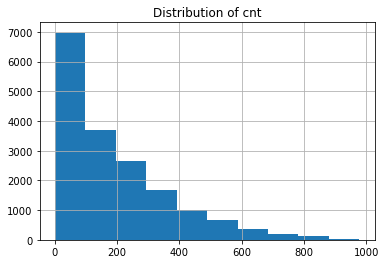

In [4]:
# Histogram of the cnt column of bike_rentals to observe the distribution of total rentals.

bike_rentals['cnt'].hist()
plt.title('Distribution of cnt')

The histogram shows the cnt column is positively skewed (skewed to the right). About 40% of rentals numbers are less than 100. 

In [5]:
# Explore how each column is correlated with cnt.

bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

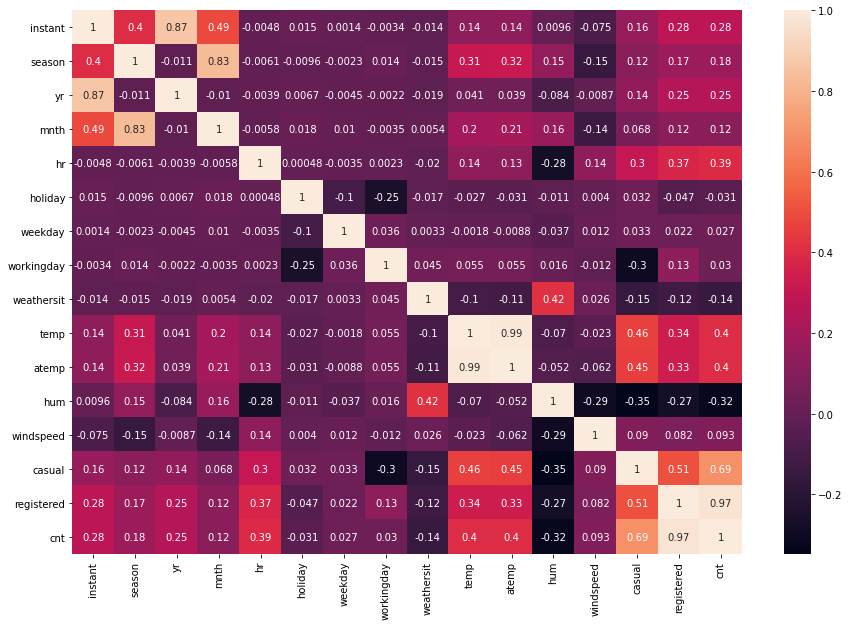

In [6]:
# These correlations can be showed graphically:

plt.figure(figsize=(15, 10))
sns.heatmap(bike_rentals.corr(), annot=True)

In [7]:
# Let's find out which variables have an absolute correlation with cnt (total number of bike rentals) greater than 0.3:

corr_coefficients = abs(bike_rentals.corr()['cnt'])
corr_coefficients[corr_coefficients>0.3].sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
Name: cnt, dtype: float64

Excluding registered and casual columns since cnt is the sum of them, the following columns have high correlations with the cnt column:

- temperature
- hour
- humidity

## Feature Engineering 

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

We will create a function assign_label() that takes in a numeric value for an hour and returns:

- 1 if the hour is from 6 to 12
- 2 if the hour is from 12 to 18
- 3 if the hour is from 18 to 24
- 4 if the hour is from 0 to 6

In [8]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3


In [9]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
bike_rentals['time_label'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Train and Test Data Sets 

Before applying machine learning methods, we need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. As if you train an algorithm on the training data, then evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.

We will select 80% of the rows in bike_rentals to be part of the training set with the rest of the rows part of the testing set.

In [10]:
train = bike_rentals.sample(frac = .8, random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (13903, 18)
test shape:  (3476, 18)


The following metrics are used to evaluate the performance of the machine learning algorithms:

- Root of the mean square (RMSE): This gives us an absolute number on how much our predicted results deviate from the actual number. Each model is applied to both the training and test data set and then the RMSE os calculated for both (called training error and validation error).

- R-Squared (R2): This indicates how much of the variance in observations the model accounts for. It is a good measure to determine how well the model fits the dependent variables. It is a value between 0 and 1 and generally a higher value is better but unrealistically too high values can be a sign of overfitting.

- Difference between training and validation error: To avoid overfitting, we will minimize the difference between these two errors while also trying to minimize the RMSEs and looking for a high enough R-Squared value. 

To compare results between models and parameters, a combined error score will be calculated as follows:

((1/2)(rmse1(0.4) + rmse2(0.6))) + ((-1/4)(r2_1(0.5) + r2_2(0.5))) + (1/4)(abs(rmse2 - rmse1))

where:

- rmse1: RMSE from training dataset
- rmse2: RMSE from test dataset
- r2_1: R2 from training dataset
- r2_2: R2 from test dataset

So, we give greater weight towards the RMSEs for training and test datasets but more weight is given to the RMSE for the test dataset as decision tree models are prone to overfitting and we could end up with a model that has a very low average RMSE being best even though it is highly overfitted and a poor predictor of data outside the training dataset. 

## Feature Selection

We need to create a list of predictor columns to use in training and testing machine learning models. We ignore the 'casual' and 'registered' columns because cnt is derived from them. 

'temp' and 'atemp' columns are highly correlated so one of them is sufficient for prediction. Thus, we exclude 'atemp' column. 

We exclude 'dteday' since it is not numeric and its data is mentioned in other columns. We also remove 'instant' as it is only an id. The target variable 'cnt' is removed as it cannot be its own predictor. 

In [11]:
excluded_columns = ['cnt', 'casual', 'registered','dteday', 'instant']
features = bike_rentals.columns.drop(excluded_columns)
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

# Machine Learning Methods to Predict Bike Rentals 

## 1: Linear Regression

Linear regression should work fairly well on this data, given that many of the columns are highly correlated with cnt, as linear regression works best when predictors are linearly correlated to the target and also independent - in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

In [12]:
def linear_regression(train , test, features, target):
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = linear_regression(train, train, features, 'cnt')
test_error = linear_regression(train, test, features, 'cnt')
print("Linear Regression")
print("*************************")
print("train error (rmse, r2):", train_error)
print("validation error (rmse, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Linear Regression
*************************
train error (rmse, r2): (132.6124243916765, 0.4702152740503345)
validation error (rmse, r2): (130.5946379586095, 0.46211423723840306)
Difference:  -2.017786433067016


The errors should be explained in comparison with the errors of other models but they look high at first glance. This may bb because the data has a few extremely high rental counts but otherwise mostly low counts and large errors are penalized more with RMSE or MSE measurements which leads to a higher total error.  

Also, both training and validation errors are high and the training error is higher than the validation error. So the model seems too poor for prediction and there is a probability of underfitting.

## 2: Decision Tree Algorithm 

We now apply a decision tree algorithm and will compare the error performance of this model to that of the linear regression model to pick the right algorithm for this dataset.

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability - small changes in the input data can result in a very different output model.

In [13]:
def DecisionTreeRegressor_model(train, test, feature, target, min_samples_leaf = 1, max_depth = None):
    dtr = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    dtr.fit(train[features], train[target])
    predictions = dtr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = DecisionTreeRegressor_model(train, train, features, 'cnt')
test_error = DecisionTreeRegressor_model(train, test, features, 'cnt')
print("Decision Tree Regression with default settings")
print("***********************************************")
print("train error (rsme, r2):", train_error)
print("validation error (rsme, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Decision Tree Regression with default settings
***********************************************
train error (rsme, r2): (0.5693317794626366, 0.9999902352336465)
validation error (rsme, r2): (57.9713978521288, 0.8940095093156276)
Difference:  57.402066072666166


The error is significantly less than the error of the linear regression algorithm. This would be expected as the decision tree regressor can take nonlinear predictors into account to form more accurate predictions. However, with the current (default) parameters used, there is signs of overfitting. 

A low training error while significantly larger validation error shows overfitting. Too high r2 value for training (0.99) can also be another sign of overfitting. Let's see if we can tune the model by changing the min_samples_leaf to optimize the model's performance. 

## Decision Tree Parameter Optimization 

We will find the decision tree algorithm with the optimal minimum sample leaves and maximum depth.

In [14]:
def decision_tree_model_optimization(feature, target, min_samples_leaf = 1, max_depth = None):
    feature = features 
    
    test1 = train
    dtr1 = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    dtr1.fit(train[features], train[target])
    predictions1 = dtr1.predict(test1[features])
    mse1 = mean_squared_error(test1[target], predictions1)
    rmse1 = np.sqrt(mse1)
    r2_1 = r2_score(test1[target], predictions1)
    
    
    test2 = test
    dtr2 = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    dtr2.fit(train[features], train[target])
    predictions2 = dtr2.predict(test2[features])
    mse2 = mean_squared_error(test2[target], predictions2)
    rmse2 = np.sqrt(mse2)
    r2_2 = r2_score(test2[target], predictions2)
    
    combined_performance = ((1/2)*(rmse1*0.4 + rmse2*0.6)) + ((-1/4)*(r2_1*0.5 + r2_2*0.5)) + (1/4)*abs(rmse2 - rmse1)
    
    return combined_performance


In [15]:
# Find possible combinations of minimum sample leaves and maximum depth:

# Range of values to consider:
range_values = range(1,20,1)

# List of possible combinations for minimum sample leaves and maximum depth:
combinations = []

for subset in itertools.combinations(range_values, 2):
    # Convert values stored as tuples into lists
    subset_values = [item for item in subset]
    combinations.append(subset_values)

# Add combinations in reverse order e.g. [3, 2] instead of only [2, 3]:
combo_copy = combinations.copy()
for combo in combo_copy:
    combinations.append([combo[1], combo[0]])
    
# Add double values like e.g. [2,2], [3,3] ... 
for subset in itertools.combinations(range_values, 1):
    # Convert values stored as tuples into lists
    subset_values = [item for item in subset]
    subset_values.append([item for item in subset][0])
    combinations.append(subset_values)

# Add max_depth = None and min_sample_leaves combinations:
nones = [ [i, None] for i in range(1,20,1)]
for n in nones:
    combinations.append(n)
    
print(len(combinations)) 
print(combinations)

380
[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 18], [2, 19], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 16], [3, 17], [3, 18], [3, 19], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [4, 11], [4, 12], [4, 13], [4, 14], [4, 15], [4, 16], [4, 17], [4, 18], [4, 19], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [5, 11], [5, 12], [5, 13], [5, 14], [5, 15], [5, 16], [5, 17], [5, 18], [5, 19], [6, 7], [6, 8], [6, 9], [6, 10], [6, 11], [6, 12], [6, 13], [6, 14], [6, 15], [6, 16], [6, 17], [6, 18], [6, 19], [7, 8], [7, 9], [7, 10], [7, 11], [7, 12], [7, 13], [7, 14], [7, 15], [7, 16], [7, 17], [7, 18], [7, 19], [8, 9], [8, 10], [8, 11], [8, 12], [8, 13], [8, 14], [8, 15], [8, 16], [8, 17], [8, 1

In [16]:
# Dictionary to store combined error score:

# Key is in format: min_samples_leaf, max_depth:
optimal_dict_decision_tree = {}

for combo in combinations:
    optimal_dict_decision_tree[combo[0],combo[1]] = decision_tree_model_optimization(features, 'cnt', min_samples_leaf = combo[0], max_depth = combo[1])

optimal_dict_decision_tree

{(1, 2): 69.67433781663304,
 (1, 3): 64.54034088450821,
 (1, 4): 59.4034523286042,
 (1, 5): 53.77083000000865,
 (1, 6): 50.28372605750308,
 (1, 7): 42.84064891411818,
 (1, 8): 38.22845765262524,
 (1, 9): 33.70994466017691,
 (1, 10): 30.842573161727064,
 (1, 11): 29.275339420215015,
 (1, 12): 29.42115175835562,
 (1, 13): 30.35111030595885,
 (1, 14): 29.717685417592755,
 (1, 15): 30.65132546040421,
 (1, 16): 30.75665849868071,
 (1, 17): 30.918315548695276,
 (1, 18): 31.173259210069247,
 (1, 19): 31.73239170658397,
 (2, 3): 64.54034088450821,
 (2, 4): 59.4034523286042,
 (2, 5): 53.77083000000865,
 (2, 6): 50.28372605750308,
 (2, 7): 42.84031143546226,
 (2, 8): 37.967469609785596,
 (2, 9): 33.22074446446328,
 (2, 10): 30.679116191223518,
 (2, 11): 28.593315218059157,
 (2, 12): 28.878859876507377,
 (2, 13): 28.815314846987373,
 (2, 14): 28.95465569956196,
 (2, 15): 28.697714089710132,
 (2, 16): 28.8671355893243,
 (2, 17): 29.045244584510822,
 (2, 18): 29.273538774038137,
 (2, 19): 29.569929

In [17]:
# Find optimal combination

def optimal_parameters(optimal_dictionary):
    base_optimal_combo = combinations[0]
    base_optimal_score = optimal_dictionary[combinations[0][0], combinations[0][1]]
    
    for k in optimal_dictionary:
        if optimal_dictionary[k] < base_optimal_score:
            base_optimal_combo = k
            base_optimal_score = optimal_dictionary[k]
        else:
            pass
        
    return base_optimal_combo, base_optimal_score 

In [18]:
print("For the decision tree model, the optimal minimum number of leaves is:",str(optimal_parameters(optimal_dict_decision_tree)[0][0]),"and the optimal maximum depth is:",str(optimal_parameters(optimal_dict_decision_tree)[0][1]))

For the decision tree model, the optimal minimum number of leaves is: 8 and the optimal maximum depth is: None


## 3: Random Forests 

We now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. However, random forests are prone to overfitting, so it's important we tune parameters like maximum depth and minimum samples per leaf to avoid this and obtain the optimal model. 

In [19]:
def random_forest_model(train, test, feature, target, n_estimators = 100, min_samples_leaf = 1, max_depth = None):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state=1, min_samples_leaf = min_samples_leaf, max_depth = max_depth)
    rf.fit(train[feature], train[target])
    predictions = rf.predict(test[feature])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test[target], predictions)
    return rmse, r2

train_error = random_forest_model(train, train, features, 'cnt')
test_error = random_forest_model(train, test, features, 'cnt')
print("random_forest_model with default setting")
print("***********************************************")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0])

random_forest_model with default setting
***********************************************
train error: (15.895826268783399, 0.992388027359284)
validation error: (44.310634484224785, 0.9380765285401584)
Difference:  28.414808215441386


## Random Forests Parameter Optimization 

We will find the random forest algorithm with the optimal minimum sample leaves and maximum depth. In doing so we use the default number of trees (estimators) which is 100. This is for time purposes. In theory we could also search for the optimal number of trees (or just choose a larger number of trees as more trees provides greater accuracy) however this would take considerably more time and the impact of increasing the number of trees on accuracy is subject to diminishing returns. 

In [20]:
def random_forest_model_optimization(feature, target, n_estimators = 100, min_samples_leaf = 1, max_depth = None):
    feature = features 
    
    test1 = train
    rf1 = RandomForestRegressor(n_estimators = n_estimators, random_state=1, min_samples_leaf = min_samples_leaf, max_depth = max_depth)
    rf1.fit(train[feature], train[target])
    predictions1 = rf1.predict(test1[feature])
    mse1 = mean_squared_error(test1[target], predictions1)
    rmse1 = np.sqrt(mse1)
    r2_1 = r2_score(test1[target], predictions1)
     
    test2 = test
    rf2 = RandomForestRegressor(n_estimators = n_estimators, random_state=1, min_samples_leaf = min_samples_leaf, max_depth = max_depth)
    rf2.fit(train[feature], train[target])
    predictions2 = rf2.predict(test2[feature])
    mse2 = mean_squared_error(test2[target], predictions2)
    rmse2 = np.sqrt(mse2)
    r2_2 = r2_score(test2[target], predictions2)
    
    combined_performance = ((1/2)*(rmse1*0.4 + rmse2*0.6)) + ((-1/4)*(r2_1*0.5 + r2_2*0.5)) + (1/4)*abs(rmse2 - rmse1)
    
    return combined_performance

In [21]:
start_time = time.time()
print(random_forest_model_optimization(features, 'cnt', n_estimators = 100, min_samples_leaf = 2, max_depth = None))

end_time = time.time()
print(f"It took {end_time-start_time:.2f} seconds to compute")

22.922476883101982
It took 8.55 seconds to compute


In [22]:
# Dictionary to store combined error score:
# Key is in format: min_samples_leaf, max_depth:

optimal_dict_random_forest = {}

for combo in combinations:
    optimal_dict_random_forest[combo[0],combo[1]] = random_forest_model_optimization(features, 'cnt', n_estimators = 100, min_samples_leaf = combo[0], max_depth = combo[1])

optimal_dict_random_forest

{(1, 2): 69.38155495034573,
 (1, 3): 64.02949739385222,
 (1, 4): 58.82431008672011,
 (1, 5): 52.970848911468885,
 (1, 6): 48.6844858877858,
 (1, 7): 39.69008926128659,
 (1, 8): 33.80319421316755,
 (1, 9): 29.293939720864408,
 (1, 10): 26.4780747684083,
 (1, 11): 25.014106420715244,
 (1, 12): 24.26264268857652,
 (1, 13): 23.800718185863033,
 (1, 14): 23.533280348074133,
 (1, 15): 23.391064544373023,
 (1, 16): 23.285522728370992,
 (1, 17): 23.320316893402,
 (1, 18): 23.335168806577485,
 (1, 19): 23.326253810646627,
 (2, 3): 64.02949739385222,
 (2, 4): 58.82431008672011,
 (2, 5): 52.970848911468885,
 (2, 6): 48.681123764169875,
 (2, 7): 39.67033740203708,
 (2, 8): 33.73035570343829,
 (2, 9): 29.160248220580517,
 (2, 10): 26.293163960060063,
 (2, 11): 24.836562725460553,
 (2, 12): 23.928482448818997,
 (2, 13): 23.500335716903056,
 (2, 14): 23.234282708732007,
 (2, 15): 23.113698940612494,
 (2, 16): 23.01817930821034,
 (2, 17): 23.023297043866908,
 (2, 18): 22.992686341798514,
 (2, 19): 22.

In [23]:
# Find optimal combination

def optimal_parameters(optimal_dictionary):
    base_optimal_combo = combinations[0]
    base_optimal_score = optimal_dictionary[combinations[0][0], combinations[0][1]]
    
    for k in optimal_dictionary:
        if optimal_dictionary[k] < base_optimal_score:
            base_optimal_combo = k
            base_optimal_score = optimal_dictionary[k]
        else:
            pass
        
    return base_optimal_combo, base_optimal_score 
            
        

In [27]:
print("For the random forest model, the optimal minimum number of leaves is:",str(optimal_parameters(optimal_dict_random_forest)[0][0]),"and the optimal maximum depth is:",str(optimal_parameters(optimal_dict_random_forest)[0][1]))

For the random forest model, the optimal minimum number of leaves is: 2 and the optimal maximum depth is: None


Therefore, 2 minimum sample leaves and no maximum depth (while all other parameters are using their default values) is the optimal random forest model. 

We could find the optimal set of parameters for all parameters (i.e. using no default values and comparing all possible combinations) however this would take too long to run. In addition, there is unlikely to be a significant improvement over the optimal combination we propose here as minimum sample leaves and maximum depth are the most common parameters to optimize over.

## Conclusion

In this project, we have used various machine learning techniques to predict bike rentals. We will now compare the results of each model. 

In [26]:
algorithms_df = pd.DataFrame(index = ['Linear Regression', 'Decision Tree Default', 'Decision Tree with Optimal Parameters', 'Random Forest Default', 'Random Forest with Optimal Parameters'],
            columns = ['train_rsme', 'train_r2', 'test_rsme', 'test_r2', 'diff_rsme'], 
            data = np.array([[linear_regression(train, train, features, 'cnt')[0], linear_regression(train, train, features, 'cnt')[1], linear_regression(train, test, features, 'cnt')[0], linear_regression(train, test, features, 'cnt')[1], linear_regression(train, test, features, 'cnt')[0] - linear_regression(train, train, features, 'cnt')[0]],
                             [DecisionTreeRegressor_model(train, train, features, 'cnt')[0], DecisionTreeRegressor_model(train, train, features, 'cnt')[1], DecisionTreeRegressor_model(train, test, features, 'cnt')[0], DecisionTreeRegressor_model(train, train, features, 'cnt')[1], DecisionTreeRegressor_model(train, test, features, 'cnt')[0] - DecisionTreeRegressor_model(train, train, features, 'cnt')[0]],
                             [DecisionTreeRegressor_model(train, train, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[0], DecisionTreeRegressor_model(train, train, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[1], DecisionTreeRegressor_model(train, test, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[0], DecisionTreeRegressor_model(train, test, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[1], DecisionTreeRegressor_model(train, test, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[0] - DecisionTreeRegressor_model(train, train, features, 'cnt', min_samples_leaf = optimal_parameters(optimal_dict_decision_tree)[0][0], max_depth = optimal_parameters(optimal_dict_decision_tree)[0][1])[0]],
                             [random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = 1, max_depth = None)[0], random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = 1, max_depth = None)[1], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = 1, max_depth = None)[0], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = 1, max_depth = None)[1], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = 1, max_depth = None)[0] - random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = 2, max_depth = None)[0]],
                             [random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[0], random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[1], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[0], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[1], random_forest_model(train, test, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[0] - random_forest_model(train, train, features, 'cnt', n_estimators = 100, min_samples_leaf = optimal_parameters(optimal_dict_random_forest)[0][0], max_depth = optimal_parameters(optimal_dict_random_forest)[0][1])[0]]]))

algorithms_rounded_df = algorithms_df.round(decimals=3)
algorithms_rounded_df

,train_rsme,train_r2,test_rsme,test_r2,diff_rsme
Linear Regression,132.612,0.470,130.595,0.462,-2.018
Decision Tree Default,0.569,1.000,57.971,1.000,57.402
Decision Tree with Optimal Parameters,40.560,0.950,53.786,0.909,13.226
Random Forest Default,15.896,0.992,44.311,0.938,21.941
Random Forest with Optimal Parameters,22.370,0.985,44.148,0.939,21.778


Thus using our error metric as described earlier, which combines RMSE, R-Squared and differential RMSE values for test and train datasets but weighs most heavily on RMSE test and train dataset values, the random forest method with optimal parameters (2 minimum sample leaves and no maximum depth) is the optimal model across the 3 machine learning methods covered in this project.   